In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
image_path = "/content/drive/MyDrive/Colab Notebooks/CFL_training_data"

In [10]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(image_path, 'input_wall'))[:1000]:
  input_images.append(cv2.resize(cv2.imread(os.path.join(image_path, 'input_wall', image)), (256,256)))
  output_image_path = os.path.join(image_path, 'output_wall', image).replace('.jpg', '.png')
  output_images.append(cv2.resize(cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE), (256,256))/255)
output_images = [image[..., np.newaxis] for image in output_images]

In [9]:
import cv2
import os
import numpy as np

input_images = []
output_images = []

for image in os.listdir(os.path.join(image_path, 'input_wall'))[:1000]:
    # Load and resize input image
    img = cv2.resize(cv2.imread(os.path.join(image_path, 'input_wall', image)), (256, 256))

    # Convert image to YCrCb
    img_y_cr_cb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)

    # Create a CLAHE object (with clip limit and tile grid size specified)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    # Apply CLAHE to the Y channel
    img_y_cr_cb[:,:,0] = clahe.apply(img_y_cr_cb[:,:,0])

    # Convert back to BGR color space
    img_clahe = cv2.cvtColor(img_y_cr_cb, cv2.COLOR_YCrCb2BGR)

    # Append the processed image to the input_images list
    input_images.append(img_clahe)

    # Process output image (kept as is from your original code)
    output_image_path = os.path.join(image_path, 'output_wall', image).replace('.jpg', '.png')
    output_images.append(cv2.resize(cv2.imread(output_image_path, cv2.IMREAD_GRAYSCALE), (256,256))/255)

# Preparing the output images (kept as is from your original code)
output_images = [image[..., np.newaxis] for image in output_images]



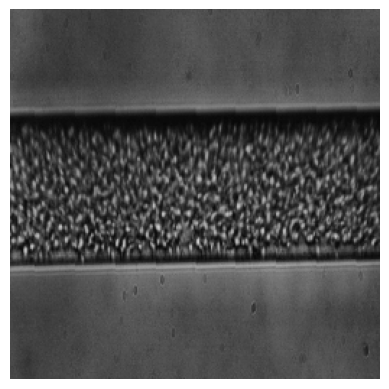

(256, 256, 3)


In [10]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

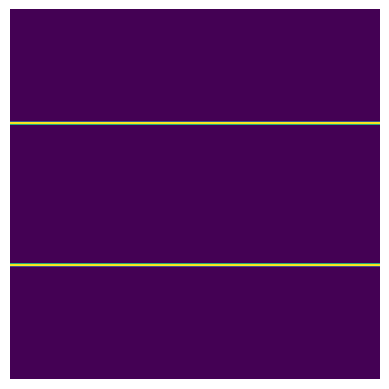

(256, 256, 1)


In [11]:
plt.imshow(output_images[1])
plt.axis('off')
plt.show()
print(output_images[0].shape)

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [14]:
def unet_plus_plus(input_shape=(256, 256, 3), num_filters=64):
    inputs = Input(input_shape)

    # Downsampling
    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, num_filters * 2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv_block(p2, num_filters * 4)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv_block(p3, num_filters * 8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv_block(p4, num_filters * 16)

    # Upsampling
    u6 = Conv2DTranspose(num_filters * 8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv_block(u6, num_filters * 8)

    u7 = Conv2DTranspose(num_filters * 4, (3, 3), strides=(2, 2), padding="same")(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv_block(u7, num_filters * 4)

    u8 = Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding="same")(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv_block(u8, num_filters * 2)

    u9 = Conv2DTranspose(num_filters, (3, 3), strides=(2, 2), padding="same")(c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(0.1)(u9)
    c9 = conv_block(u9, num_filters)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c9)

    #model = Model(inputs=[inputs], outputs=[outputs], name = "U-Net++")
    model = Model(inputs=[inputs], outputs=[outputs], name="U_Net_Plus_Plus")


    return model


In [15]:
model = unet_plus_plus()
model.summary()

Model: "U_Net_Plus_Plus"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normaliz

In [16]:
import tensorflow as tf
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=tf.keras.losses.binary_crossentropy, metrics=['binary_accuracy'])
model.fit(x=np.array(input_images),
    y=np.array(output_images),
    validation_split=0.2,
    batch_size=8,
    epochs=40,
    shuffle=False)

Epoch 1/40
100/100 [==============================] - 112s 733ms/step - loss: 0.2850 - binary_accuracy: 0.9580 - val_loss: 101.1708 - val_binary_accuracy: 0.0732
Epoch 2/40
100/100 [==============================] - 75s 751ms/step - loss: 0.1499 - binary_accuracy: 0.9819 - val_loss: 1.3916 - val_binary_accuracy: 0.8794
Epoch 3/40
100/100 [==============================] - 75s 754ms/step - loss: 0.1190 - binary_accuracy: 0.9824 - val_loss: 0.2323 - val_binary_accuracy: 0.9830
Epoch 4/40
100/100 [==============================] - 75s 754ms/step - loss: 0.0980 - binary_accuracy: 0.9837 - val_loss: 0.1235 - val_binary_accuracy: 0.9789
Epoch 5/40
100/100 [==============================] - 75s 749ms/step - loss: 0.0772 - binary_accuracy: 0.9879 - val_loss: 0.0988 - val_binary_accuracy: 0.9770
Epoch 6/40
100/100 [==============================] - 75s 754ms/step - loss: 0.0644 - binary_accuracy: 0.9899 - val_loss: 0.0885 - val_binary_accuracy: 0.9807
Epoch 7/40
100/100 [=======================

In [17]:
model.save(os.path.join(image_path, 'unet_plus_plus_wall_40epochs.hdf5'))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
from tensorflow.keras.models import load_model

model_path = "/content/drive/MyDrive/Colab Notebooks/CFL_training_data/unet_plus_plus_wall_40epochs.hdf5"


model = load_model(model_path)

In [12]:
# Predicting on the first 5 images
pred = model.predict(np.array(input_images[:5]))

1/1 [==============================] - 11s 11s/step


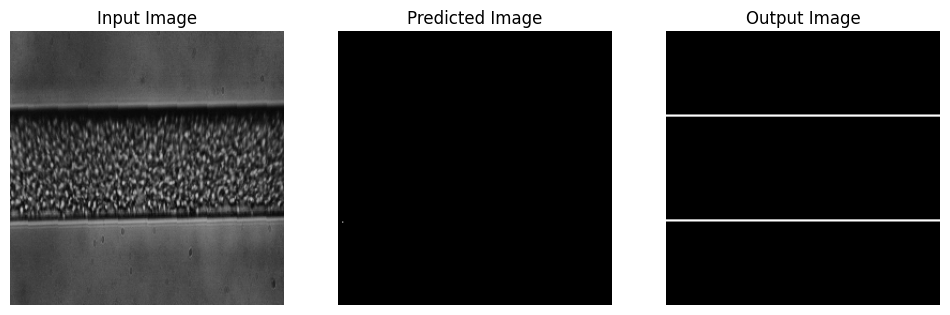

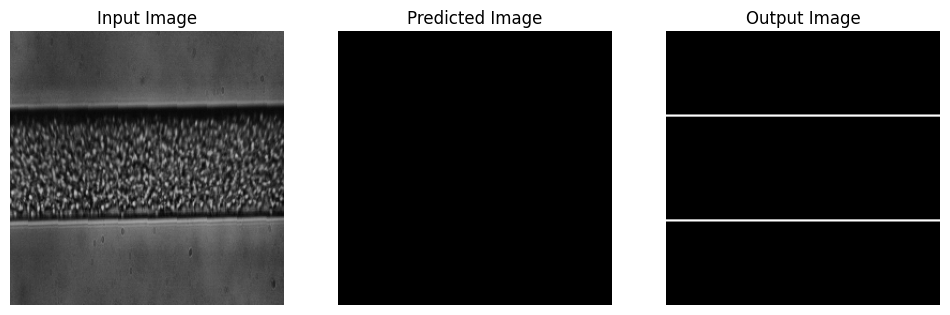

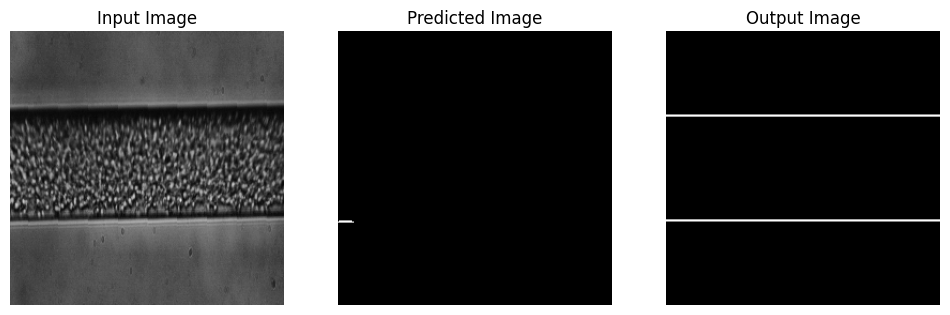

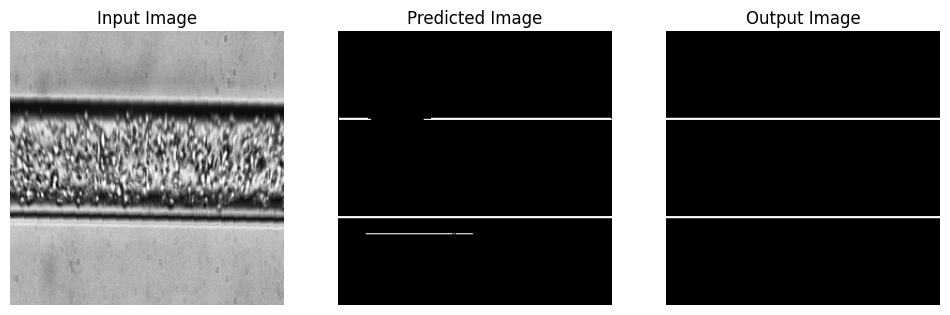

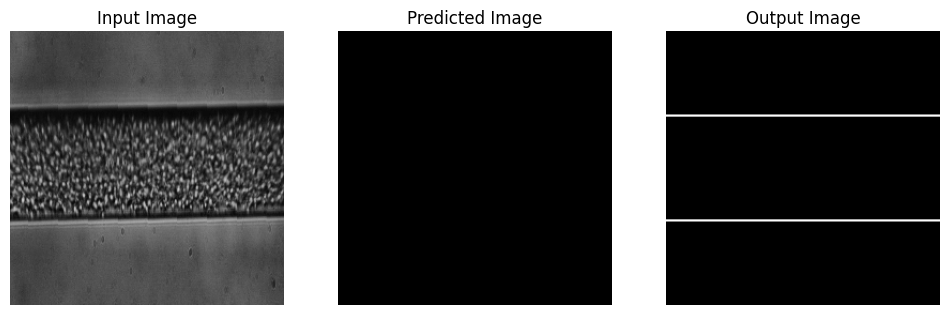

In [13]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_images[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(output_images[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()

In [14]:
# Calculate the index for the validation split
validation_split = 0.2
split_index = int(len(input_images) * (1 - validation_split))

val_input_images = input_images[split_index:split_index + 5]
val_output_images = output_images[split_index:split_index + 5]

val_input = np.array(val_input_images)
val_output = np.array(val_output_images)

val_pred = model.predict(val_input)

1/1 [==============================] - 11s 11s/step


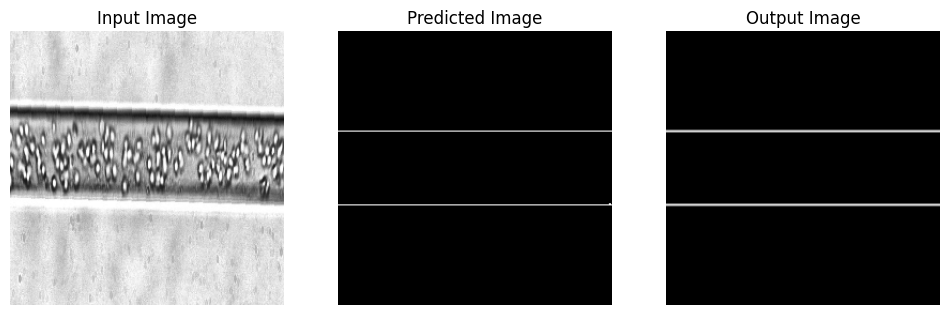

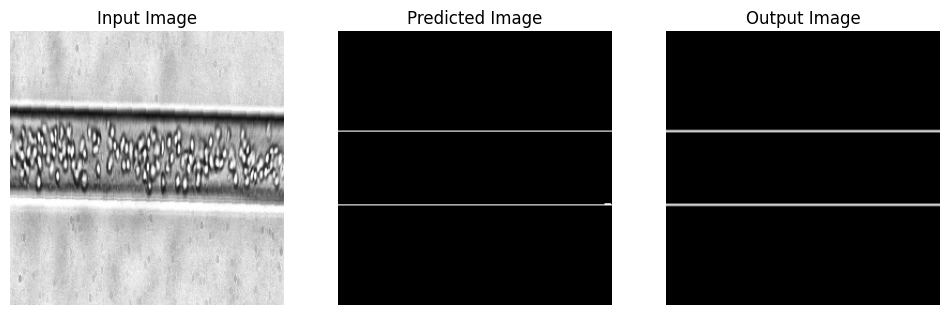

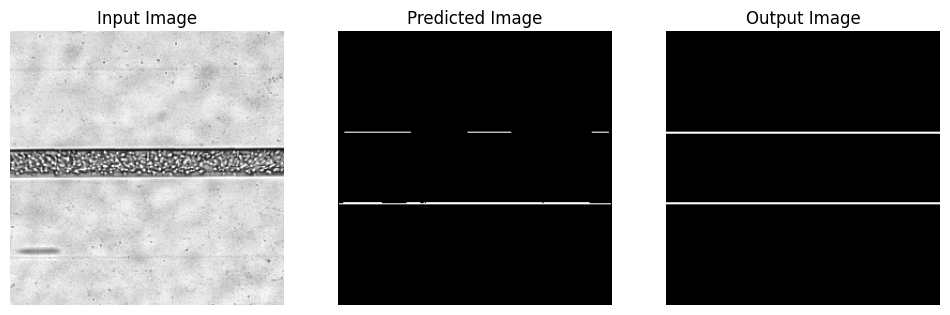

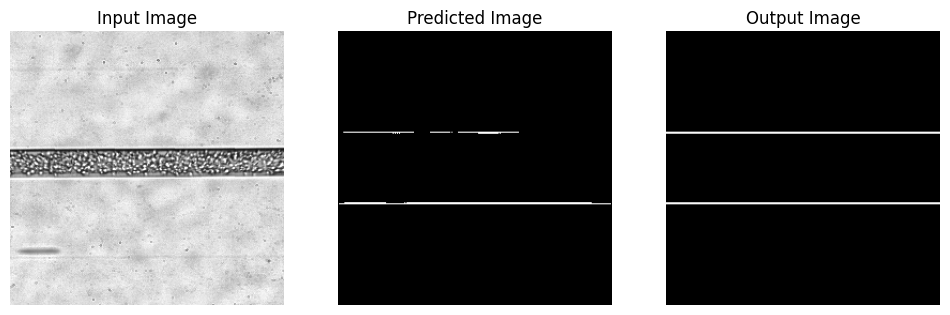

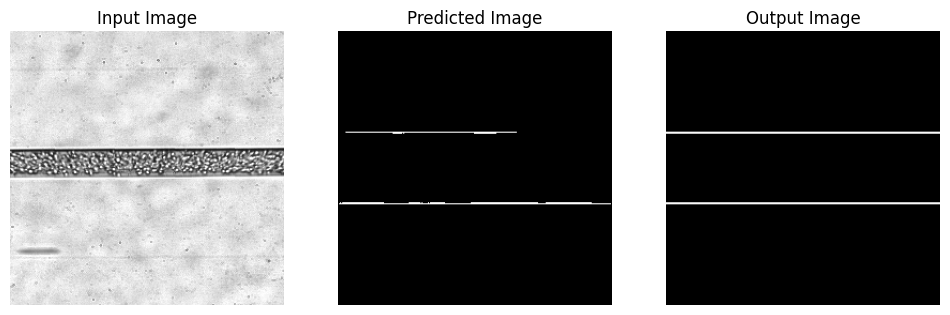

In [15]:
# Plotting the input, predicted, and output images without threshold
for i in range(5):
    plt.figure(figsize=(12, 6))

    # Display input image
    plt.subplot(1, 3, 1)
    plt.imshow(val_input[i])
    plt.title("Input Image")
    plt.axis('off')

    # Display predicted image without threshold
    plt.subplot(1, 3, 2)
    plt.imshow(val_pred[i]>0.8, cmap='gray', vmin=0, vmax=1)
    plt.title("Predicted Image")
    plt.axis('off')

    # Display corresponding output image
    plt.subplot(1, 3, 3)
    plt.imshow(val_output[i][:, :, 0], cmap='gray', vmin=0, vmax=1)  # Assuming output_images are normalized
    plt.title("Output Image")
    plt.axis('off')

    plt.show()